Wybieramy temat. Może być to temat z pierwszego projektu. Jeśli pozostajemy przy tym 
samym temacie musimy znaleźć zmienną celu. 
2. Dokonujemy eksploracji zbioru. Uzupełniamy braki danych. Dokonujemy wstępnej selekcji 
zmiennych.   
3. Dzielimy zbiór danych na treningowy testowy i w miarę możliwości na walidacyjny. 
4. Tworzymy minimum 3 modele predykcyjne (może być ich więcej) wraz z dostrojeniem 
hiperparametrów. 
5. Porównać i wybrać najlepszy model. 
6. Dokonać ostatecznej oceny wybranego modelu na zbiorze walidacyjnym. 
7. Wskazać uzysk dla firmy / odbiorcy (np. ile pieniędzy z tego będzie miała, jak wdrożenie 
wpłynie na rozpoznawalność przypadków, dla których firma wykona działania prewencyjne 
itd.) 
8. Stworzenie aplikacji wykorzystującej model 
9. Na prezentacji powinna znaleźć się krótka analiza zmiennych, omówienie wyników 
wszystkich zastosowanych technik modelowania i ich porównanie, wybór modelu i przede 
wszystkim wartość dodana jaką niesie za sobą wdrożenie

4. Odejdzie  czy nie odejdzie?  – prognozowanie zjawiska churn wśród Klientów telecom  
• Prognozowanie czy jest zagrożenie, że Klient zrezygnuje z usług firmy 
• Aplikacja dla pracowników informująca o zagrożeniu odejścia Klienta 
• https://www.kaggle.com/blastchar/telco-customer-churn 
 


In [1]:
#Import libraries
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_selection import SelectKBest,mutual_info_classif, f_classif, RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV,validation_curve,cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,precision_score,recall_score,f1_score, roc_auc_score, make_scorer,roc_curve
from sklearn.preprocessing import StandardScaler,MinMaxScaler, Normalizer, LabelEncoder,OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import chi2
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

plt.rcParams["figure.figsize"] = (20,3) 

Data Import

In [2]:
#Import data 
df=pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

#During training attempt it turned out TotalCharges has empty strings and cannot be converted to number, let's remove it. 
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')
df.dropna(inplace=True)

#drop customer ID as not useful
df.drop('customerID',axis=1,inplace=True)

Split df into X,y and into test, val, train

In [3]:
#Define X,y
X=df.drop(columns='Churn')
y=df['Churn']

#Encode y
le=LabelEncoder()
y=le.fit_transform(y)

#Splity X,y into train, val, test
X_train, X_val, y_train, y_val = train_test_split(X,y,random_state=44,train_size=0.6,stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, random_state=44,train_size=0.5,stratify=y_val)

print(X_train.shape,y_train.shape,y_train.sum()/len(y_train))
print(X_val.shape,y_val.shape,y_val.sum()/len(y_val))
print(X_test.shape,y_test.shape,y_test.sum()/len(y_test))

(4219, 19) (4219,) 0.2657027731689974
(1406, 19) (1406,) 0.26600284495021337
(1407, 19) (1407,) 0.2658137882018479


Pipeline definition for X transformation

In [4]:
#Lets split features by type 
cols_num=X.select_dtypes(include=['float64','int64']).columns
cols_cat=X.select_dtypes(include='object').columns

#Lets define pipeline that will use standard scale on numerical, onehotencoder on categorical and then run randomforrest
#lets apply standard scaler to numerical columns 
trans_num = Pipeline(steps = [
    ('num_trans', StandardScaler())
])

#lets apply one hot encoder to categorical columns
trans_cat = Pipeline(steps = [
    ('cat_trans', OneHotEncoder(drop='first'))
])

# combine above transformers into preprocessor that will transform numerical by standardscaler and categoricaly by onehot
prep_std_onehot = ColumnTransformer(transformers = [
    ('numerical', trans_num, cols_num),
    ('categorical', trans_cat, cols_cat)
])

#let's define pipe that will do preprocessing (standard scaler + one hot encoder) and then randomforrest
std_onehot_not_tuned = Pipeline(steps = [
                ('preprocessor', prep_std_onehot),
                ('classifier', RandomForestClassifier(random_state=44,n_jobs=-1))
            ])


#Lets define another pipeline that will use standard scaler on numerical, ordinal encoder on categorical and then run randomforrest

#lets apply ordinal encoding 
trans_cat_ordinal = Pipeline(steps = [
    ('cat_trans', OrdinalEncoder())
])

prep_std_ordinal = ColumnTransformer(transformers = [
    ('numerical', trans_num, cols_num),
    ('categorical', trans_cat_ordinal, cols_cat)
])

std_ordinal_not_tuned = Pipeline(steps = [
                ('preprocessor', prep_std_ordinal),
                ('classifier', RandomForestClassifier(random_state=44,n_jobs=-1))
            ])

In [6]:
def results_print(model):
    """function takes model and prints scores"""
    pred_train=model.predict(X_train)
    pred_val=model.predict(X_val)
    print('Train F1, Precision, Recall')
    print(f1_score(y_train,pred_train))
    print(precision_score(y_train,pred_train))
    print(recall_score(y_train,pred_train))
    print('Val F1, Precision, Recall')
    print(f1_score(y_val,pred_val))
    print(precision_score(y_val,pred_val))
    print(recall_score(y_val,pred_val))

def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

def results_print_treshold(model,t):
    """function takes model and prints scores depedning on treshold t"""
    prob_train=model.predict_proba(X_train)[:,1]
    prob_val=model.predict_proba(X_val)[:,1]
    print('Results for treshold {}'.format(t))
    print('F1 score with optimal treshold',f1_score(y_val,to_labels(prob_val,t)))
    print(classification_report(y_val,to_labels(prob_val,t)))
    print('Train F1, Precision, Recall')
    print(f1_score(y_train,to_labels(prob_train,t)))
    print(precision_score(y_train,to_labels(prob_train,t)))
    print(recall_score(y_train,to_labels(prob_train,t)))
    print('Val F1, Precision, Recall')
    print(f1_score(y_val,to_labels(prob_val,t)))
    print(precision_score(y_val,to_labels(prob_val,t)))
    print(recall_score(y_val,to_labels(prob_val,t)))

Evaluate std_onehot_not_tuned (base model).

In [7]:
#Fit model
std_onehot_not_tuned.fit(X_train,y_train)

#Evaluate model
results_print(std_onehot_not_tuned)

Train F1, Precision, Recall
0.9968819599109132
0.9955516014234875
0.9982158786797503
Val F1, Precision, Recall
0.580060422960725
0.6666666666666666
0.5133689839572193


Evaluate std_ordinal_not_tuned (standard scaler + ordinal encoding).

It's 0.0028 better on recall form based model

In [8]:
#Fit model
std_ordinal_not_tuned.fit(X_train,y_train)

#Evaluate model
results_print(std_ordinal_not_tuned)

Train F1, Precision, Recall
0.9968819599109132
0.9955516014234875
0.9982158786797503
Val F1, Precision, Recall
0.5873493975903614
0.6724137931034483
0.5213903743315508


Tune & Evaluate std_one_hot hyperparams. 

In [9]:
#Hyperparameters for grid search and instantiation of gridsearch
params_grid= {
    'classifier__max_depth': [None,3,5,7,9,10,12,14,17,20],
    'classifier__class_weight': [None,'balanced'],
    'classifier__max_features': [None,'auto','log2'],
    'classifier__min_samples_leaf': [1,3,5,10,15,20]
}

std_onehot_tuned=GridSearchCV(std_onehot_not_tuned,params_grid,scoring='f1',n_jobs=-1,verbose=2)

#Find the optimal hyperparmeters
std_onehot_tuned.fit(X_train,y_train)

#print optimal paramaters
std_onehot_tuned.best_params_

#Evaluate model
results_print(std_onehot_tuned)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Train F1, Precision, Recall
0.7058380414312617
0.6108213820078227
0.8358608385370205
Val F1, Precision, Recall
0.6482758620689656
0.5685483870967742
0.7540106951871658


Evaluate std_onehot_tuned with best treshold.

Its better by 0.3248 on recall than our base model



Best Threshold=0.442234, G-Mean=0.781


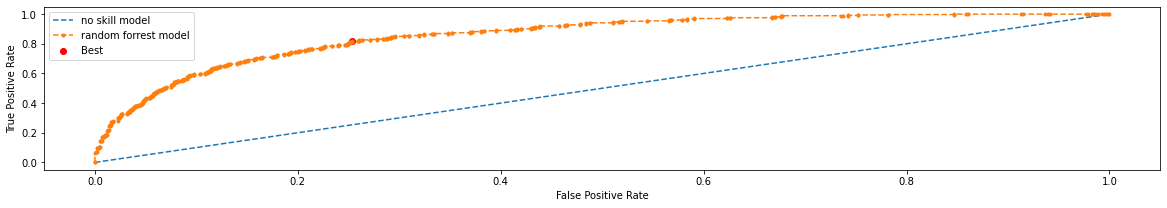

Results for treshold 0.4422335756517446
F1 score with optimal treshold 0.648936170212766
              precision    recall  f1-score   support

           0       0.92      0.75      0.82      1032
           1       0.54      0.82      0.65       374

    accuracy                           0.77      1406
   macro avg       0.73      0.78      0.74      1406
weighted avg       0.82      0.77      0.78      1406

Train F1, Precision, Recall
0.701949860724234
0.575671045117076
0.8991971454058876
Val F1, Precision, Recall
0.648936170212766
0.5388692579505301
0.8155080213903744


In [10]:
#Let's find optimal treshold with which we can improve the model

#Le'ts calc false and true positive rates depending on treshold
fpr, tpr, thresholds = roc_curve(y_val, std_onehot_tuned.predict_proba(X_val)[:,1])

#Let's find optimal treshold at which model ability to predict 0 and 1 is best balanced.
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='no skill model')
plt.plot(fpr, tpr, marker='.', linestyle='--', label='random forrest model')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

results_print_treshold(std_onehot_tuned,thresholds[ix])

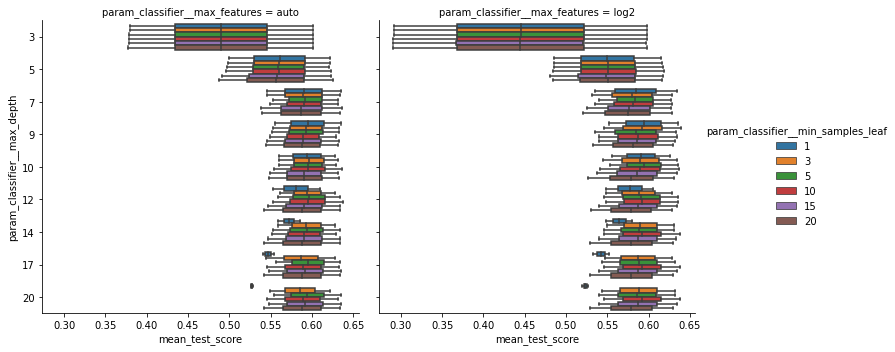

In [216]:
#Lets visualize Gridsearh results
results=pd.DataFrame(std_onehot_tuned.cv_results_)

#Shows f1 score depending on max depth (y_axis) and min_samples_leaf(color). This needs loop to split other dimension (i.e. max_features, class_weight)
sns.catplot(data=results, x='mean_test_score', y='param_classifier__max_depth',hue='param_classifier__min_samples_leaf',kind="box",col="param_classifier__max_features")

# sns.lineplot(data=results,x='param_classifier__max_depth',y='mean_test_score')

# sns.relplot(
#     data=results,x='param_classifier__max_depth', y='mean_test_score',
#     col='param_classifier__max_features',
#     kind="line"
# )

Try undersampling - std_onehot_undersampled_not_tuned

In [41]:
# define model
model = RandomForestClassifier(random_state=44,n_jobs=-1)
# define resampling
under = RandomUnderSampler(sampling_strategy=0.5)

from imblearn.pipeline import Pipeline as imbPipeline
# define pipeline
std_onehot_undersample = imbPipeline(steps=[('u', under), ('e',prep_std_onehot), ('classifier', model)])

In [42]:
std_onehot_undersample.fit(X_train,y_train)

Pipeline(steps=[('u', RandomUnderSampler(sampling_strategy=0.5)),
                ('e',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('num_trans',
                                                                   StandardScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat_trans',
                                                                   OneHotEncoder(drop='first'))]),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 

Evaluate std_onehot_undersampled_not_tuned

Its 0.1624 better on recall than our base model

In [45]:
#Evaluate model
results_print(std_onehot_undersample)

ValueError: X has 30 features, but DecisionTreeClassifier is expecting 19 features as input.

Tune std_onehot_undersampled hyperparameters

In [16]:
params_grid= {
    'classifier__max_depth': [None,3,5,7,9,10,12,14,17,20],
    'classifier__class_weight': [None,'balanced'],
    'classifier__max_features': [None,'auto','log2'],
    'classifier__min_samples_leaf': [1,3,5,10,15,20]
}

std_onehot_undersampled_tuned=GridSearchCV(std_onehot_undersample,params_grid,scoring='f1',n_jobs=-1,verbose=2)

In [17]:
std_onehot_undersampled_tuned.fit(X_train,y_train)
std_onehot_undersampled_tuned.best_params_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


{'classifier__class_weight': 'balanced',
 'classifier__max_depth': 17,
 'classifier__max_features': 'auto',
 'classifier__min_samples_leaf': 15}

Evaluate std_onehot_undersampled_tuned
Its better on recall by 0.3590



In [23]:
#Evaluate model
results_print(std_onehot_undersampled_tuned)

Train F1, Precision, Recall
0.6705160591844099
0.563030303030303
0.8287243532560215
Val F1, Precision, Recall
0.6549835706462211
0.5547309833024119
0.7994652406417112


Evaluate std_onehot_undersampled_tuned with best treshold

Its 0.3391 better on recall than base model

Best Threshold=0.500153, G-Mean=0.783


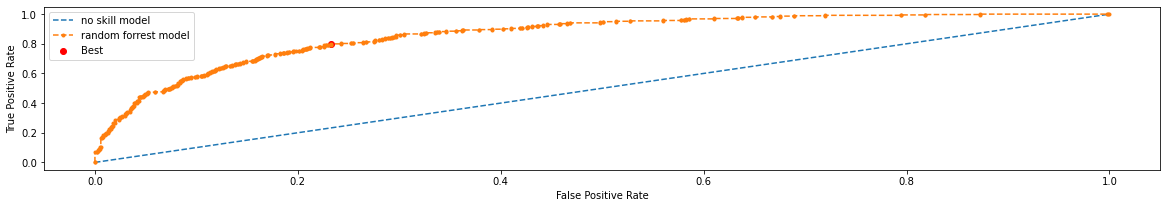

Results for treshold 0.5001528514397381
F1 score with optimal treshold 0.6549835706462211
              precision    recall  f1-score   support

           0       0.91      0.77      0.83      1032
           1       0.55      0.80      0.65       374

    accuracy                           0.78      1406
   macro avg       0.73      0.78      0.74      1406
weighted avg       0.82      0.78      0.79      1406

Train F1, Precision, Recall
0.6705160591844099
0.563030303030303
0.8287243532560215
Val F1, Precision, Recall
0.6549835706462211
0.5547309833024119
0.7994652406417112


In [24]:
#Let's find optimal treshold with which we can improve the model

#Le'ts calc false and true positive rates depending on treshold
fpr, tpr, thresholds = roc_curve(y_val, std_onehot_undersampled_tuned.predict_proba(X_val)[:,1])

#Let's find optimal treshold at which model ability to predict 0 and 1 is best balanced.
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='no skill model')
plt.plot(fpr, tpr, marker='.', linestyle='--', label='random forrest model')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

results_print_treshold(std_onehot_undersampled_tuned,thresholds[ix])

#Tune std_ordinal hyperparameters

In [21]:
#Hyperparameters for grid search and instantiation of gridsearch
params_grid= {
    'classifier__max_depth': [None,3,5,7,9,10,12,14,17,20],
    'classifier__class_weight': [None,'balanced'],
    'classifier__max_features': [None,'auto','log2'],
    'classifier__min_samples_leaf': [1,3,5,10,15,20]
}

std_ordinal_tuned=GridSearchCV(std_ordinal_not_tuned,params_grid,scoring='f1',n_jobs=-1,verbose=2)

In [22]:
#Find the optimal hyperparmeters
std_ordinal_tuned.fit(X_train,y_train)

#print optimal paramaters
std_ordinal_tuned.best_params_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


{'classifier__class_weight': 'balanced',
 'classifier__max_depth': 7,
 'classifier__max_features': 'auto',
 'classifier__min_samples_leaf': 10}

Evaluate std_ordinal_tuned

Its 0.3391  better than base model

In [25]:
#See the precision, recall & f1 score for train and val with optimal hyperparameters
#Evaluate model
results_print(std_ordinal_tuned)

Train F1, Precision, Recall
0.6767193821257815
0.5757196495619524
0.8206958073148974
Val F1, Precision, Recall
0.6481069042316259
0.5553435114503816
0.7780748663101604


(54,82) std_ordinal_tuned with best treshold

Best Threshold=0.465755, G-Mean=0.780


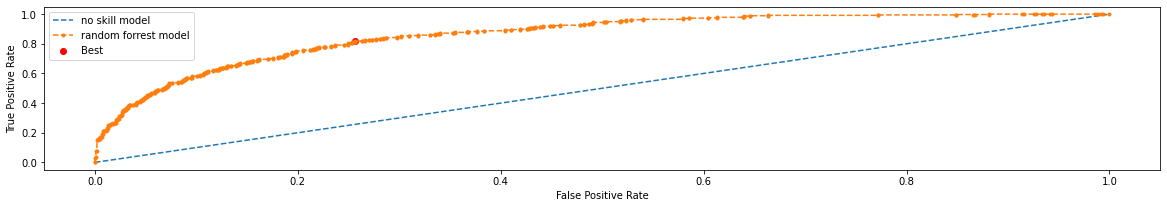

Results for treshold 0.4657549427276706
F1 score with optimal treshold 0.6476190476190476
              precision    recall  f1-score   support

           0       0.92      0.74      0.82      1032
           1       0.54      0.82      0.65       374

    accuracy                           0.76      1406
   macro avg       0.73      0.78      0.73      1406
weighted avg       0.82      0.76      0.78      1406

Train F1, Precision, Recall
0.6697022767075307
0.5513264129181085
0.8528099910793934
Val F1, Precision, Recall
0.6476190476190476
0.5359019264448336
0.8181818181818182


In [27]:
#Let's find optimal treshold with which we can improve the model

#Le'ts calc false and true positive rates depending on treshold
fpr, tpr, thresholds = roc_curve(y_val, std_ordinal_tuned.predict_proba(X_val)[:,1])

#Let's find optimal treshold at which model ability to predict 0 and 1 is best balanced.
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='no skill model')
plt.plot(fpr, tpr, marker='.', linestyle='--', label='random forrest model')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

results_print_treshold(std_ordinal_tuned,thresholds[ix])

Evaluate std_ordinal_undersampled_not_tuned

In [44]:
std_ordinal_undersampled_not_tuned = imbPipeline(steps=[('u', under), ('e',prep_std_ordinal), ('classifier', model)])
std_ordinal_undersampled_not_tuned.fit(X_train,y_train)

Pipeline(steps=[('u', RandomUnderSampler(sampling_strategy=0.5)),
                ('e',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('num_trans',
                                                                   StandardScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat_trans',
                                                                   OrdinalEncoder())]),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMet

In [29]:
results_print(std_ordinal_undersampled_not_tuned)


Train F1, Precision, Recall
0.9467455621301776
0.8995983935742972
0.9991079393398751
Val F1, Precision, Recall
0.6153846153846153
0.6212534059945504
0.6096256684491979


Evaluate std_ordinal_undersampled_tuned

In [30]:
#Hyperparameters for grid search and instantiation of gridsearch
params_grid= {
    'classifier__max_depth': [None,3,5,7,9,10,12,14,17,20],
    'classifier__class_weight': [None,'balanced'],
    'classifier__max_features': [None,'auto','log2'],
    'classifier__min_samples_leaf': [1,3,5,10,15,20]
}

std_ordinal_undersampled_tuned=GridSearchCV(std_ordinal_not_tuned,params_grid,scoring='f1',n_jobs=-1,verbose=2)

In [31]:
std_ordinal_undersampled_tuned.fit(X_train,y_train)
std_ordinal_undersampled_tuned.best_params_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


{'classifier__class_weight': 'balanced',
 'classifier__max_depth': 7,
 'classifier__max_features': 'auto',
 'classifier__min_samples_leaf': 10}

In [33]:
results_print(std_ordinal_undersampled_tuned)

Train F1, Precision, Recall
0.6767193821257815
0.5757196495619524
0.8206958073148974
Val F1, Precision, Recall
0.6481069042316259
0.5553435114503816
0.7780748663101604


(54,82) std_ordinal_undersampled_tuned with best treshold

Best Threshold=0.465755, G-Mean=0.780


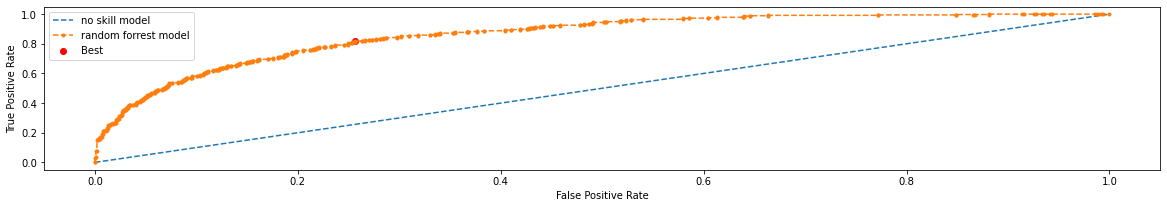

Results for treshold 0.2
F1 score with optimal treshold 0.5427286356821589
              precision    recall  f1-score   support

           0       0.97      0.42      0.59      1032
           1       0.38      0.97      0.54       374

    accuracy                           0.57      1406
   macro avg       0.68      0.69      0.57      1406
weighted avg       0.81      0.57      0.58      1406

Train F1, Precision, Recall
0.5564475664826894
0.38708551483420595
0.9892952720785013
Val F1, Precision, Recall
0.5427286356821589
0.3770833333333333
0.9679144385026738


In [37]:
#Let's find optimal treshold with which we can improve the model

#Le'ts calc false and true positive rates depending on treshold
fpr, tpr, thresholds = roc_curve(y_val, std_ordinal_undersampled_tuned.predict_proba(X_val)[:,1])

#Let's find optimal treshold at which model ability to predict 0 and 1 is best balanced.
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='no skill model')
plt.plot(fpr, tpr, marker='.', linestyle='--', label='random forrest model')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

results_print_treshold(std_ordinal_undersampled_tuned,thresholds[ix])

In [39]:
#Lets aggregate results

# will iterate over those models
models={
    "std_onehot_not_tuned": std_onehot_not_tuned,
    "std_onehot_tuned": std_onehot_tuned,
    "std_onehot_undersampled_not_tuned": std_onehot_undersample,
    "std_onehot_undersampled_tuned": std_onehot_undersampled_tuned,
    "std_ordinal_not_tuned": std_ordinal_not_tuned,
    "std_ordinal_tuned": std_ordinal_tuned,
    # "std_ordinal_undersampled_not_tuned": std_ordinal_undersampled_not_tuned,
    # "std_ordinal_undersampled_tuned": std_ordinal_undersampled_tuned
}



#we will use this function to collect results
def collect_results(model_lst):
    #we will use those lists to collect results
    model_list=[]
    f1_train=[]
    prec_train=[]
    rec_train=[]
    f1_val=[]
    prec_val=[]
    rec_val=[]
    for model in model_lst:
        model_list.append(model)
        print(model)
        f1_train.append(f1_score(y_train,model_lst[model].predict(X_train)))
        prec_train.append(precision_score(y_train,model_lst[model].predict(X_train)))
        rec_train.append(recall_score(y_train,model_lst[model].predict(X_train)))
        f1_val.append(f1_score(y_val,model_lst[model].predict(X_val)))
        prec_val.append(precision_score(y_val,model_lst[model].predict(X_val)))
        rec_val.append(recall_score(y_val,model_lst[model].predict(X_val)))
    return pd.DataFrame({'model': model_list, 'f1_train': f1_train, 'precision_trian': prec_train,'recall_train': rec_train,
    'f1_val': f1_val, 'precision_val': prec_val,'recall_val': rec_val
    })


Compare models

In [40]:
display(collect_results(models))
# pipeline.predict(X_train)

# f1_=[]

# taratara = {'mod1': pipe}
# for key in taratara:
#     print(f1_score(y_train,taratara[key].predict(X_train)))
#     f1_.append(f1_score(y_train,taratara[key].predict(X_train)))

# print(f1_)

std_onehot_not_tuned
std_onehot_tuned
std_onehot_undersampled_not_tuned


ValueError: X has 30 features, but DecisionTreeClassifier is expecting 19 features as input.